# Amazon Product Recommendation System

##  Data Description
Data columns-  First three columns are userId, productId, and ratings and the fourthcolumn is timestamp. You can discard the timestamp column as in this case you maynot need to use it.

In [1]:
# Utilities
import math, random, warnings
from time import time
from datetime import datetime
from collections import defaultdict
from IPython.core.interactiveshell import InteractiveShell

# Mathematical calculation
import numpy as np
from scipy.sparse.linalg import svds
from sklearn import model_selection
from sklearn.metrics.pairwise import cosine_similarity

# Data handling
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-surprise recommender package
from surprise import SVD, KNNWithMeans
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from surprise.prediction_algorithms.baseline_only import BaselineOnly

# Configure for any default setting of any library
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')
%matplotlib inline
# sns.set(style='whitegrid', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
df=pd.read_csv("D:\\PGP AIML\\009_Recommender_Systems\\ratings_Electronics.csv",
               names=['userId', 'productId', 'rating', 'timestamp'])

In [3]:
# Check the head of the dataset
df.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.00,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.00,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.00,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.00,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.00,1334707200


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [5]:
df.shape

(7824482, 4)

In [6]:
df.nunique()

userId       4201696
productId     476002
rating             5
timestamp       5489
dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,7824482.00,4.01,1.38,1.00,3.00,5.00,5.00,5.00
timestamp,7824482.00,1338178197.27,69004257.79,912729600.00,1315353600.00,1361059200.00,1386115200.00,1406073600.00


In [8]:
# Check for any Null values in the dataset
df.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

In [9]:
# Get a dataframe consisting only of ratings that are duplicated
rating_combination = ['userId', 'productId']
df[df.duplicated(subset=rating_combination, keep=False)].sort_values(rating_combination).head()

,userId,productId,rating,timestamp


In [10]:
# Convert the timestamp column to a readable date time format
df['timestamp'] = df.timestamp.apply(lambda ts: datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))
# Convert the datatype to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()
df.info()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.00,2013-04-13
1,A2CX7LUOHB2NDG,0321732944,5.00,2012-07-01
2,A2NWSAGRHCP8N5,0439886341,1.00,2013-04-29
3,A2WNBOD3WNDNKT,0439886341,3.00,2013-07-22
4,A1GI0U4ZRJA8WN,0439886341,1.00,2012-04-18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     object        
 1   productId  object        
 2   rating     float64       
 3   timestamp  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 238.8+ MB


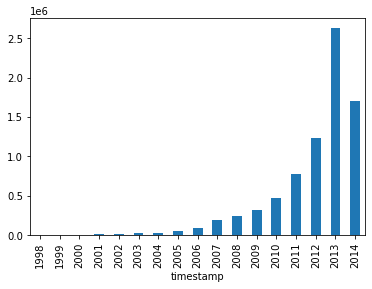

In [11]:
year_wise_count = df.timestamp.groupby(df['timestamp'].dt.year).count()
_ = year_wise_count.plot(kind='bar')

In [12]:
# Drop the timestamp column
df.drop(labels='timestamp', axis=1, inplace=True)
df.head()

,userId,productId,rating
0,AKM1MP6P0OYPR,0132793040,5.00
1,A2CX7LUOHB2NDG,0321732944,5.00
2,A2NWSAGRHCP8N5,0439886341,1.00
3,A2WNBOD3WNDNKT,0439886341,3.00
4,A1GI0U4ZRJA8WN,0439886341,1.00


In [13]:
# Check the count of unique user and product data
unique_original = (df.userId.nunique(), df.productId.nunique())
print('Count of unique Users    :', unique_original[0])
print('Count of unique Products :', unique_original[1])

Count of unique Users    : 4201696
Count of unique Products : 476002


In [14]:
print("The Minimum rating is:",df.rating.min())
print("The Maximum rating is:",df.rating.max())

The Minimum rating is: 1.0
The Maximum rating is: 5.0


Count of observations in each ratings:


5.00    4347541
4.00    1485781
1.00     901765
3.00     633073
2.00     456322
Name: rating, dtype: int64

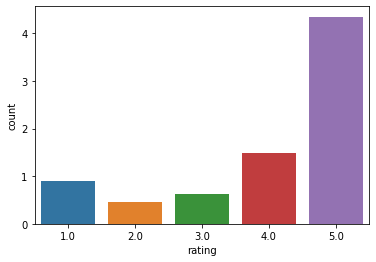

In [15]:
# Check the distribution of ratings 
print('Count of observations in each ratings:')
df.rating.value_counts()
g = sns.countplot("rating", data=df)
g.yaxis.get_offset_text().set_visible(False)

In [16]:
# Find the top 10 users based on ratings
most_rated = df.userId.value_counts().rename_axis('UserId').reset_index(name='Ratings')
most_rated.head(10)

,UserId,Ratings
0,A5JLAU2ARJ0BO,520
1,ADLVFFE4VBT8,501
2,A3OXHLG6DIBRW8,498
3,A6FIAB28IS79,431
4,A680RUE1FDO8B,406
5,A1ODOGXEYECQQ8,380
6,A36K2N527TXXJN,314
7,A2AY4YUOX2N1BQ,311
8,AWPODHOB4GFWL,308
9,ARBKYIVNYWK3C,296


In [17]:
# Drop the users who have rated less than 50 products
df = df[df.userId.isin(most_rated[most_rated['Ratings'] >= 50].UserId)]
print('Unique USERS who have rated 50 or more products :', df.userId.nunique())
print('Unique USERS dropped      :', unique_original[0] - df.userId.nunique())
print('Unique ITEMS remaining    :', df.productId.nunique())
print('Unique ITEMS dropped      :', unique_original[1] - df.productId.nunique())
print('\nFinal length of the dataset :', len(df))

Unique USERS who have rated 50 or more products : 1540
Unique USERS dropped      : 4200156
Unique ITEMS remaining    : 48190
Unique ITEMS dropped      : 427812

Final length of the dataset : 125871


In [18]:
# Divide the dataset in 70:30 ratio
train, test = model_selection.train_test_split(df, test_size=0.3, random_state=5)
train.head()
test.head()

,userId,productId,rating
5815696,A197T2N6RU7K56,B007N6OED8,5.00
412740,A3HR0ZZOFKQ97N,B0001Y7UAI,5.00
444340,AGHZXQL9F94T9,B0002A6YVC,2.00
3481712,A2XJMQ2COPGWJH,B003NSBF32,2.00
4580022,A2D1LPEUCTNT8X,B004YKKT26,4.00


,userId,productId,rating
4930282,A2UOHALGF2X77Q,B005G81E9M,3.00
3333831,A27M75LRSJ788H,B003FG6IV6,5.00
7490425,A35W3JQYP0M655,B00E3FHXYO,5.00
679608,A1FR68QH6Z4YZM,B0009R3N9E,5.00
583942,A25FL6VLD7S23S,B00079Q5DK,2.00


In [19]:
print('Shape of the training set  :', train.shape)
print('Shape of the test set      :', test.shape)

Shape of the training set  : (88109, 3)
Shape of the test set      : (37762, 3)


Text(0.5, 1.0, 'Training Set')

Text(0.5, 1.0, 'Testing Set')

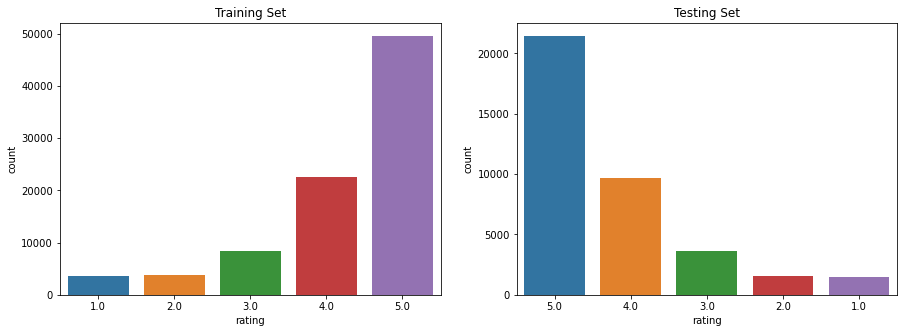

In [20]:
# Check the ratings distribution in both train and test set
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].set_title('Training Set')
sns.countplot('rating', data=train, ax=axes[0])
axes[1].set_title('Testing Set')
sns.countplot('rating', data=test, ax=axes[1], order=test.rating.value_counts().index)

## Popularity Recommender model. (Non-personalised)

In [21]:
# Create a method to recommend products based on popularity
def recommend_popular(df, top_n, userId=None):
    # Generate a recommendation rank based upon score 
    df['Rank'] = df['score'].rank(ascending=0, method='first') 
    recommendations = df.sort_values(['score', 'productId'], ascending=[0,1])
    
    # Add UserId column for which the recommendations are being generated 
    if userId:
        recommendations.insert(0,'userId',userId)
    
    # Get the top N recommendations 
    return recommendations.head(top_n)

### Method 1: UserId count for each unique product as recommended score

In [22]:
#Count of user_id for each unique product as recommendation score 
product_grp = df.groupby(['productId']).agg({'userId': 'count'}).reset_index()
product_grp.rename(columns={'userId': 'score'}, inplace=True)
product_grp.head()

,productId,score
0,0594451647,1
1,0594481813,1
2,0970407998,2
3,0972683275,4
4,1400501466,6


In [23]:
# Find recommendation for top 5 products
recommend_popular(product_grp, 5)

,productId,score,Rank
39003,B0088CJT4U,206,1.00
24827,B003ES5ZUU,184,2.00
11078,B000N99BBC,167,3.00
38250,B007WTAJTO,164,4.00
38615,B00829TIEK,149,5.00


### Method 2: Average of ratings for each unique product as recommended score

In [24]:
#Count of user_id for each unique product as recommendation score 
product_grp = df.groupby(['productId']).agg({'rating': 'mean'}).reset_index()
product_grp.rename(columns={'rating': 'score'}, inplace=True)
product_grp.head()

,productId,score
0,0594451647,5.00
1,0594481813,3.00
2,0970407998,2.50
3,0972683275,4.75
4,1400501466,3.33


In [25]:
# Find recommendation for top 5 products
recommend_popular(product_grp, 5)

,productId,score,Rank
0,0594451647,5.00,1.00
5,1400501520,5.00,2.00
12,1400699169,5.00,3.00
13,1685560148,5.00,4.00
14,3744295508,5.00,5.00


### Method 3: Sum of ratings for each unique product as recommended score

In [26]:
#Count of user_id for each unique product as recommendation score 
product_grp = df.groupby(['productId']).agg({'rating': 'sum'}).reset_index()
product_grp.rename(columns={'rating': 'score'}, inplace=True)
product_grp.head()

,productId,score
0,0594451647,5.00
1,0594481813,3.00
2,0970407998,5.00
3,0972683275,19.00
4,1400501466,20.00


In [27]:
# Find recommendation for top 5 products
recommend_popular(product_grp, 5)

,productId,score,Rank
24827,B003ES5ZUU,895.00,1.00
39003,B0088CJT4U,869.00,2.00
11078,B000N99BBC,797.00,3.00
38250,B007WTAJTO,771.00,4.00
38615,B00829TIEK,661.00,5.00


In [28]:
# Find recommendation for couple of users
find_recom = {'A197T2N6RU7K56': 4, 
              'A1FR68QH6Z4YZM': 3, 
              'A10AFVU66A79Y1': 5}   # This list is user, top_n recommendation dict.
for user in find_recom:
    print("Top %d recommendations for the userId: %s" %(find_recom[user],user))
    recommend_popular(product_grp,find_recom[user],user)
    print("\n")

Top 4 recommendations for the userId: A197T2N6RU7K56


,userId,productId,score,Rank
24827,A197T2N6RU7K56,B003ES5ZUU,895.00,1.00
39003,A197T2N6RU7K56,B0088CJT4U,869.00,2.00
11078,A197T2N6RU7K56,B000N99BBC,797.00,3.00
38250,A197T2N6RU7K56,B007WTAJTO,771.00,4.00




Top 3 recommendations for the userId: A1FR68QH6Z4YZM


,userId,productId,score,Rank
24827,A1FR68QH6Z4YZM,B003ES5ZUU,895.00,1.00
39003,A1FR68QH6Z4YZM,B0088CJT4U,869.00,2.00
11078,A1FR68QH6Z4YZM,B000N99BBC,797.00,3.00




Top 5 recommendations for the userId: A10AFVU66A79Y1


,userId,productId,score,Rank
24827,A10AFVU66A79Y1,B003ES5ZUU,895.00,1.00
39003,A10AFVU66A79Y1,B0088CJT4U,869.00,2.00
11078,A10AFVU66A79Y1,B000N99BBC,797.00,3.00
38250,A10AFVU66A79Y1,B007WTAJTO,771.00,4.00
38615,A10AFVU66A79Y1,B00829TIEK,661.00,5.00


## Collaborative Filtering model

Collaborative filtering is the process of filtering out information or patterns using techniques involving collaboration among multiple agents, viewpoints, data sources, etc.This is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on a matter, A is more likely to have B's opinion on a different matter than that of a randomly chosen person.

This technique doesn’t need anything else except users’ historical preference on a set of items. Because it’s based on historical data. In terms of user preference, it usually expressed by two categories.

**Explicit Rating** : It is a rate given by a user to an item on a sliding scale, like 5 stars for any movie or an item. This is the most direct feedback from users to show how much they like an item.

**Implicit Rating**: This suggests users' preference indirectly, such as page views, clicks, purchase records, whether or not listen to a music track, and so on.
Nearest Neighborhood - The standard method of Collaborative Filtering is known as Nearest Neighborhood algorithm.

Types of Collaborative Filtering (CF)

- **Item Based Collaborative Filtering (IBCF)**

Compute similarity between Items

- **User Based Collaborative Filtering (UBCF)**

Compute similarity between Users
IBCF vs. UBCF

 IBCF is more efficient than UBCF. Typical applications involve far more Users than Items. Hence Similarity matrix for IBCF is more compact than UBCF. Similarity estimates between items is also more likely to converge over time than similarity between users. Hence the similarities can be pre computed and cached unlike similarity between users that need to be dynamically computed at every certain interval.However, the IBCF recommendations tend to be more conservative than UBCF

**Similarity Metrics**: 

The following are the two popular similarity metrics used in recommender systems. 

- **Jaccard Similarity** is useful when the User/Item Matrix contain binary values

- **Cosine Similarity**: Similarity is the cosine of the angle between the 2 item vectors represented by:

$$Cosine\;Similarity:CosSim(x,y)=\frac{\sum_i{x_iy_i}}{\sqrt{\sum{(x_i)^2}}\sqrt{\sum{(y_i)^2}}}=\frac{\langle x, y \rangle}{\|x\|\|y\|}$$

**Pearson Correlation**: Similarity is the Pearson correlation between two vectors represented by:

$$Pearson\;Correlation:Corr(x, y)=\frac{\sum_i{(x_i-\bar{x})(y_i-\bar{y})}}{\sqrt{\sum{(x_i-\bar{x})^2}}\sqrt{\sum{(y_i-\bar{y})^2}}}=\frac{\langle x-\bar{x}, y-\bar{y} \rangle}{\|x-\bar{x}\|\|y-\bar{y}\|}=CosSim(x-\bar{x},\;y-\bar{y})$$



### User Based Collaborative Filtering (UBCF)
This algorithm first finds the similarity score between users. Based on this similarity score, it then picks out the most similar users and recommends products which these similar users have liked or bought previously.

$$\widehat{r}_{ui}=\frac{\sum_{v\in{N_i^k(u)}}{similarity(u,v).r_{vi}}}{\sum_{v\in{N_i^k(u)}}{similarity(u,v)}}$$

### Item Based Collaborative Filtering (IBCF)
This algorithm first finds the similarity score between items. Based on this similarity score, it then picks out the most similar items and recommends that to the user which these similar items have been liked or bought previously.

$$\widehat{r}_{ui}=\frac{\sum_{j\in{N_u^k(i)}}{similarity(i,j).r_{uj}}}{\sum_{j\in{N_u^k(j)}}{similarity(i,j)}}$$

First step is to create the sparse matrix.

In [29]:
# Create the User-Item sparse matrix
user_item = df.pivot(index='userId', columns='productId', values='rating').fillna(0)
print('Shape of User-Item sparse matrix:', user_item.shape)
user_item.head()

Shape of User-Item sparse matrix: (1540, 48190)


productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A100WO06OQR8BQ,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A105S56ODHGJEK,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A105TOJ6LTVMBG,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A10AFVU66A79Y1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [30]:
# Create the Item-User sparse matrix
item_user = df.pivot(index='productId', columns='userId', values='rating').fillna(0)
print('Shape of Item-User sparse matrix:', item_user.shape)
item_user.head()

Shape of Item-User sparse matrix: (48190, 1540)


userId,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
productId,,,,,,,,,,,,,,,,,,,,,
0594451647,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0594481813,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0970407998,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0972683275,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1400501466,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


We can now use the cosine_similarity function from sklearn to calculate the cosine similarity.

In [31]:
# Calculate the user-user similarity
user_similarity = cosine_similarity(user_item)
np.fill_diagonal(user_similarity, 0)
user_similarity_df = pd.DataFrame(user_similarity,index=user_item.index, columns=user_item.index)
user_similarity_df.head()

userId,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.00,0.01,0.00,0.01,0.03,0.00,0.02,0.03,0.01,0.02,...,0.02,0.00,0.00,0.03,0.04,0.00,0.00,0.04,0.02,0.01
A100WO06OQR8BQ,0.01,0.00,0.01,0.02,0.01,0.01,0.01,0.02,0.02,0.00,...,0.02,0.00,0.01,0.00,0.02,0.02,0.00,0.02,0.00,0.00
A105S56ODHGJEK,0.00,0.01,0.00,0.00,0.02,0.07,0.00,0.00,0.03,0.00,...,0.00,0.00,0.03,0.00,0.01,0.00,0.00,0.00,0.02,0.00
A105TOJ6LTVMBG,0.01,0.02,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,...,0.04,0.00,0.01,0.00,0.02,0.02,0.00,0.04,0.00,0.00
A10AFVU66A79Y1,0.03,0.01,0.02,0.00,0.00,0.02,0.00,0.00,0.00,0.01,...,0.00,0.00,0.02,0.04,0.05,0.00,0.00,0.00,0.00,0.00


In [32]:
# Calculate the item-item similarity
item_similarity = cosine_similarity(item_user)
np.fill_diagonal(item_similarity, 0)
item_similarity_df = pd.DataFrame(item_similarity, index=item_user.index, columns=item_user.index)
item_similarity_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
productId,,,,,,,,,,,,,,,,,,,,,
0594451647,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0594481813,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0970407998,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0972683275,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.26,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1400501466,0.00,0.00,0.00,0.00,0.00,0.54,0.42,0.00,0.00,0.52,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [33]:
# Method to find top N neighbors
def find_n_neighbors(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(axis=1, func=lambda x: pd.Series(x.sort_values(ascending=False).iloc[:n].index,
                                                   index=['top{}'.format(i) for i in range(1, n+1)]))
    return df

In [34]:
# Find 10 neighbors of each user
user_10_neighbors = find_n_neighbors(user_similarity_df, 10)
user_10_neighbors.head(10)

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
userId,,,,,,,,,,
A100UD67AHFODS,A2FZQF0MH29VYN,A11FX8HL2ANK6T,A3CG93783LP0FO,A2NOW4U7W3F7RI,A2LB4FLRZG6CUV,A2DG63DN704LOI,AT53ZTTO707MB,A2XX2A4OJCDNLZ,A33XMCG1UFDSY2,A2YW6XOID7GV6G
A100WO06OQR8BQ,A3963R7EPE3A7E,A30UP2KKD5IQEP,A2Y3WWPUKIJ59I,A298GL2D0BHGKZ,A1CST2WUA32GP0,A15XI2BEGGFEOW,A3D822N1K2IAQD,A2L4ZGN7GZJ95T,A18S2VGUH9SCV5,AXP8GO5Q3AXSA
A105S56ODHGJEK,A17UNMURMLX0ZE,ABMNX856X89CS,ANTN61S4L7WG9,A2LF16F0KX9L7P,A2UKE7GIVC7XFW,AJX9A4Q19UTJU,A2R1HUYHXV7H18,A3J3ZHGDUDPCFL,A1WXG10FJ353K0,A20L63B48RPSOH
A105TOJ6LTVMBG,A1TQBAHI3M4ZBQ,A10ZFE6YE0UHW8,A2XXBZPQT5EXHV,A1NZLRAZJGD99W,A1D27BCSYV7VWH,AVTJEWTCJ3PBE,AAK6SOEJY30YG,A2GKMXRLI7KLFP,A2VCXIAWCPQ13P,AKSFZ4G1AXYFC
A10AFVU66A79Y1,ACQYIC13JXAOI,A25QJBK33C4O0R,A2PMR2PIGWKCQ9,A4H4KYSM2KQ85,A2TVH2OBNXYXHV,A84FLVDK2R5JF,A2UOHALGF2X77Q,A24RCBRDXRXR0Y,A2IFKH3TJ10387,A3JLOIXFM75QNV
A10H24TDLK2VDP,ANTN61S4L7WG9,A2QRXQPHDMFCQV,A3V2EZ6MA32FF6,A3SP7T2PZ3HSDE,AO09RWV40IX78,A3J3ZHGDUDPCFL,A3QNQQKJTL76H0,A1RL1OTV8IJMVD,A19W47CXJJP1MI,A3LDLV1GWQJLEQ
A10NMELR4KX0J6,ARC5ASW9CUAGP,A1PS4OYWUB0VX,A3F7USIDJBR8WU,A3GX0FAMEXV6FB,A32HSNCNPRUMTR,A1L5TA5UQF7EWE,A3223W5IROMYTY,A1ZPUEHF4AES86,A17W0GMB0YY83M,A2HV76MYH7UL3S
A10O7THJ2O20AG,AWSK1ZAEU1KFL,A365PBEOWM7EI7,AZ8XSDMIX04VJ,AN9CP6J4JF91X,AJEOFP6ZWY0MK,A2HRHF83I3NDGT,A24P4E3RJ6AX94,A28621TSIR5EOG,A1VLE2SH9J8WYS,A2A4X545ERLS7H
A10PEXB6XAQ5XF,A267FU71Z01CIH,A1TR1R2QKWRSRA,A2MJ8OL2FYN7CW,A1CMD08Z49PGKQ,A2BLFCOPSMBOZ9,A2CWIYIETNBAK3,A1MCH5RXDOH87H,A28X0LT2100RL1,A1PI8VBCXXSGC7,AJX9A4Q19UTJU


In [35]:
# Find 10 neighbors of each item
#item_10_neighbors = find_n_neighbors(item_similarity_df, 10)
#item_10_neighbors.head(10)

In [36]:
def get_users_similar_products(user1, user2):
    common_products = df[df.userId == user1].merge(
    df[df.userId == user2],
    on = "productId",
    how = "inner" )
    return common_products[['rating_x', 'rating_y', 'productId']].head()

In [37]:
# Check the similarity of two users
get_users_similar_products('A100UD67AHFODS', 'A2FZQF0MH29VYN')

,rating_x,rating_y,productId
0,5.00,5.00,B0002KVQBA
1,3.00,4.00,B002HWRJY4
2,4.00,5.00,B0071BTJPI
3,5.00,5.00,B0097BEFYA
4,5.00,5.00,B00A83I8G2


In [38]:
# Method to predict the rating
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [39]:
# Predict the ratings for both UBCF and IBCF
st=time()
user_prediction = predict(user_item, user_similarity, type='user')
user_prediction = pd.DataFrame(user_prediction, index=user_item.index, columns=user_item.columns)
user_prediction.head()

print('Time taken %.2fs to find out the user and item prediction' % (time()-st))

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.02,0.00,0.01,0.01,0.01,0.01,0.01,0.00,0.03,0.01,...,0.00,0.01,0.01,0.02,0.01,0.02,0.00,0.04,0.02,0.00
A100WO06OQR8BQ,0.01,0.00,0.00,0.02,0.01,0.01,0.02,0.00,0.01,0.01,...,0.00,0.02,0.00,0.01,0.01,0.00,0.01,0.01,0.01,0.00
A105S56ODHGJEK,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,...,-0.00,0.01,-0.00,0.00,0.00,-0.00,-0.00,0.02,-0.00,0.00
A105TOJ6LTVMBG,-0.00,0.00,0.00,0.01,0.01,-0.00,-0.00,-0.00,0.01,-0.00,...,-0.00,-0.00,-0.00,-0.00,0.00,0.01,-0.00,0.01,0.00,-0.00
A10AFVU66A79Y1,-0.00,-0.00,0.01,0.01,0.01,0.00,0.01,-0.00,0.00,0.00,...,-0.00,0.01,0.00,0.00,-0.00,-0.00,-0.00,0.01,0.00,-0.00


Time taken 6.00s to find out the user and item prediction


In [41]:
# Commenting out following 2 lines as it throws MemoryError due to the high sparsity
# item_prediction = predict(user_item, item_similarity, type='item')
# item_prediction = pd.DataFrame(item_prediction, index=item_user.index, columns=item_user.columns)
# item_prediction.head()

In [42]:
# Method to Recommend the items with the highest predicted ratings
def recommend_items(userId, orig_df, preds_df, top_n):
    # Get and sort the user's ratings
    sorted_user_ratings = orig_df.loc[userId].sort_values(ascending=False) #sorted_user_ratings
    sorted_user_predictions = preds_df.loc[userId].sort_values(ascending=False) #sorted_user_predictions

    # Prepare recommendations
    recommedations = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    recommedations.index.name = 'Recommended Items'
    recommedations.columns = ['user_ratings', 'user_predictions']
    
    # Take the products which user has NOT rated
    recommedations = recommedations.loc[recommedations.user_ratings == 0] 
    recommedations = recommedations.sort_values('user_predictions', ascending=False)
    return recommedations.head(top_n)

In [43]:
# Find recommendation for couple of users using UBCF
find_recom = {'A100UD67AHFODS': 3, 
              'A105TOJ6LTVMBG': 4, 
              'A105S56ODHGJEK': 5}   # This list is user, top_n recommendation dict.
for user in find_recom:
    print("Top %d recommendations for the userId: %s" %(find_recom[user],user))
    recommend_items(user, user_item, user_prediction, find_recom[user])
    print("\n")

Top 3 recommendations for the userId: A100UD67AHFODS


,user_ratings,user_predictions
Recommended Items,,
B003ES5ZUU,0.00,0.87
B007WTAJTO,0.00,0.68
B0088CJT4U,0.00,0.51




Top 4 recommendations for the userId: A105TOJ6LTVMBG


,user_ratings,user_predictions
Recommended Items,,
B003ES5ZUU,0.00,0.78
B007WTAJTO,0.00,0.67
B001TH7GUU,0.00,0.62
B000N99BBC,0.00,0.52




Top 5 recommendations for the userId: A105S56ODHGJEK


,user_ratings,user_predictions
Recommended Items,,
B0088CJT4U,0.00,1.34
B00829THK0,0.00,0.88
B002R5AM7C,0.00,0.84
B004CLYEDC,0.00,0.84
B004CLYEFK,0.00,0.79


UBCF and IBCF uses Neighborhood approaches of collaborative recommendation system. Based on similarity metrics, the nearest neighbors are identified which are considered to be similar in terms of past history. Because of the high sparsity of the user-item matrix, it is computationally heavy to calculate the neighborhood for the user-user or item-item similarity resulting in non-reliable recommendations some time. To deal with this problem of huge sparsity, Latent Factor approach is used.

## Matrix Factorization based Collaborative Filtering
Matrix Factorization based CF works on the principle of Latent Factor approach. It deals with the latent factors of item base resulting in reducing the dimensionality of the mathematical space in one hand, and improving the performance because of the less sparsity of the resultant user-item base on the other.

Singular Value Decomposition (SVD)
Singular Value Decomposition (SVD) can be used to decompose any given Matrix, M into a product of 3 matrices as follows:

$$M=U\times\sum\times{}V^T$$Where:

- $U$: Left Singular Matrix
- $V$: Right Singular Matrix
- $\sum$: Diagonal Matrix of Latent Factors, and the values of the diagonal of $\sum$ are called the singular values

The matrix can be approximated to a lower rank by considering only the largest singular values.

In [44]:
# Trying out different latent factors
svd_list = [svds(user_item, k=k) for k in [100,250,500,750,1000]]
pred_list = [pd.DataFrame(np.dot(np.dot(svd[0], np.diag(svd[1])), svd[2]), 
                          index=user_item.index, 
                          columns=user_item.columns) for svd in svd_list]
RMSE_list = [round((((user_item.mean() - pred.mean()) ** 2).mean() ** 0.5), 5) for pred in pred_list]
RMSE_list

[0.00236, 0.00181, 0.00133, 0.00096, 0.0007]

In [45]:
# Singular Value Decomposition
U, sigma, Vt = svds(user_item, k=50)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [46]:
# Print the shape of the decomposed matrices
print('Shape of the Left Singular matrix          :', U.shape)
print('Shape of the Latent Factor Diagonal matrix :', sigma.shape)
print('Shape of the Right Singular matrix         :', Vt.shape)
U.shape, sigma.shape, Vt.shape

Shape of the Left Singular matrix          : (1540, 50)
Shape of the Latent Factor Diagonal matrix : (50, 50)
Shape of the Right Singular matrix         : (50, 48190)


((1540, 50), (50, 50), (50, 48190))

In [47]:
# Predicted ratings
svd_prediction = pd.DataFrame(np.dot(np.dot(U, sigma), Vt), index=user_item.index, columns=user_item.columns)
svd_prediction.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.01,0.00,0.00,-0.04,0.01,0.01,0.02,0.00,0.02,0.01,...,0.00,-0.06,0.00,-0.12,0.03,0.02,0.00,-0.17,0.01,-0.01
A100WO06OQR8BQ,0.00,-0.01,-0.00,0.13,0.01,-0.00,0.06,-0.00,0.02,-0.00,...,-0.00,0.01,0.00,0.03,-0.04,0.00,0.00,-0.02,-0.01,0.04
A105S56ODHGJEK,-0.00,-0.00,-0.01,0.01,0.01,-0.00,-0.00,0.01,-0.01,-0.00,...,-0.00,-0.05,0.00,-0.05,0.02,-0.00,-0.00,0.08,-0.11,0.01
A105TOJ6LTVMBG,0.00,0.01,-0.01,-0.01,0.00,0.00,-0.01,-0.00,0.00,0.00,...,0.00,-0.01,-0.00,-0.05,0.02,0.01,0.00,0.01,-0.02,-0.03
A10AFVU66A79Y1,0.00,-0.00,0.01,0.01,0.01,0.01,0.02,0.00,0.00,0.01,...,0.00,0.02,0.00,-0.02,-0.01,0.00,0.00,-0.02,0.01,0.01


In [48]:
# Find recommendation for couple of users
find_recom = {'A100UD67AHFODS': 6, 
              'A100WO06OQR8BQ': 3, 
              'A105S56ODHGJEK': 8}   # This list is user, top_n recommendation dict.
for user in find_recom:
    print("Top %d recommendations for the userId: %s" %(find_recom[user],user))
    recommend_items(user, user_item, svd_prediction, find_recom[user])
    print("\n")

Top 6 recommendations for the userId: A100UD67AHFODS


,user_ratings,user_predictions
Recommended Items,,
B0019EHU8G,0.00,1.41
B003ES5ZUU,0.00,1.10
B007OY5V68,0.00,0.99
B000JMJWV2,0.00,0.95
B009SYZ8OC,0.00,0.85
B00DTZYHX4,0.00,0.75




Top 3 recommendations for the userId: A100WO06OQR8BQ


,user_ratings,user_predictions
Recommended Items,,
B000N99BBC,0.00,1.83
B004CLYEDC,0.00,1.25
B001TH7GSW,0.00,1.01




Top 8 recommendations for the userId: A105S56ODHGJEK


,user_ratings,user_predictions
Recommended Items,,
B0088CJT4U,0.00,1.56
B004T9RR6I,0.00,1.20
B00BOHNYU6,0.00,1.03
B00ARB5FLQ,0.00,0.99
B00829THK0,0.00,0.91
B002R5AM7C,0.00,0.89
B009HQCAPQ,0.00,0.83
B0097CZHAU,0.00,0.81


## Evaluate both the models

### Root Mean Square Error (RMSE)

In [49]:
# Method to calculate RMSE for different model
def calculate_rmse(orig_df, preds_df):
    rmse_df = pd.concat([orig_df.mean(), preds_df.mean()], axis=1)
    rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
    RMSE = round(np.sqrt(((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean()), 5)
    print('\nRMSE for this recommender model = {}\n'.format(RMSE))
    return rmse_df.head()

In [50]:
#Evaluation of User Based CF
calculate_rmse(user_item, user_prediction)


RMSE for this recommender model = 0.00516



,Avg_actual_ratings,Avg_predicted_ratings
productId,,
0594451647,0.00,0.00
0594481813,0.00,0.00
0970407998,0.00,0.00
0972683275,0.01,0.01
1400501466,0.01,0.01


In [51]:
#Evaluation of Item Based CF
calculate_rmse(user_item, item_prediction)

NameError: name 'item_prediction' is not defined

In [52]:
#Evaluation of Matrix Factorization based CF
calculate_rmse(user_item, svd_prediction)


RMSE for this recommender model = 0.00275



,Avg_actual_ratings,Avg_predicted_ratings
productId,,
0594451647,0.00,0.00
0594481813,0.00,0.00
0970407998,0.00,0.00
0972683275,0.01,0.01
1400501466,0.01,0.00


## Get top - K ( K = 5) recommendations

In [53]:
# Create a list of users
users = ['A100UD67AHFODS','A100WO06OQR8BQ']
top_k = 5

In [54]:
# UBCF Recommendation
print('User Based Collaborative Filtering (UBCF)')
for user in users:
    print("Top %d recommendations for the userId: %s" %(top_k,user))
    recommend_items(user, user_item, user_prediction, top_k)
    print("\n")

User Based Collaborative Filtering (UBCF)
Top 5 recommendations for the userId: A100UD67AHFODS


,user_ratings,user_predictions
Recommended Items,,
B003ES5ZUU,0.00,0.87
B007WTAJTO,0.00,0.68
B0088CJT4U,0.00,0.51
B00G4UQ6U8,0.00,0.49
B002V88HFE,0.00,0.46




Top 5 recommendations for the userId: A100WO06OQR8BQ


,user_ratings,user_predictions
Recommended Items,,
B000N99BBC,0.00,0.88
B00829TIEK,0.00,0.75
B004CLYEDC,0.00,0.73
B00829THK0,0.00,0.65
B004CLYEFK,0.00,0.57


In [ ]:
# IBCF Recommendation
print('Item Based Collaborative Filtering (IBCF)')
for user in users:
    print("Top %d recommendations for the userId: %s" %(top_k,user))
    recommend_items(user, user_item, item_prediction, top_k)
    print("\n")

In [56]:
# SVD Recommendation
print('Matrix Factorization based Collaborative Filtering (SVD)')
for user in users:
    print("Top %d recommendations for the userId: %s" %(top_k,user))
    recommend_items(user, user_item, svd_prediction, top_k)
    print("\n")

Matrix Factorization based Collaborative Filtering (SVD)
Top 5 recommendations for the userId: A100UD67AHFODS


,user_ratings,user_predictions
Recommended Items,,
B0019EHU8G,0.00,1.41
B003ES5ZUU,0.00,1.10
B007OY5V68,0.00,0.99
B000JMJWV2,0.00,0.95
B009SYZ8OC,0.00,0.85




Top 5 recommendations for the userId: A100WO06OQR8BQ


,user_ratings,user_predictions
Recommended Items,,
B000N99BBC,0.00,1.83
B004CLYEDC,0.00,1.25
B001TH7GSW,0.00,1.01
B00834SJSK,0.00,0.95
B00AQRUW4Q,0.00,0.76


# Using SURPRISE package

Surprise is an easy-to-use Python scikit for recommender systems. The name SurPRISE roughly stands for Simple Python Recommendataion System Engine.

Installation

With pip (requirement: numpy and C compiler): $ pip install scikit-surprise

With conda: $ conda install -c conda-forge scikit-surprise

It provides various ready-to-use prediction algorithms such as baseline algorithms, neiborhood methods and matrix factorization based algorithms. We will be using BaselineOnly, KNNWithMeans and SVD algorithms to build our recommender system.

In [57]:
# Set the rating scale
reader = Reader(rating_scale=(1, 5))

# Load data from the ratings data frame into surprise DataFolds
df_surp = Dataset.load_from_df(df, reader)

# Check the type of the loaded data
type(df_surp)

surprise.dataset.DatasetAutoFolds

In [58]:
df.head()

,userId,productId,rating
94,A3BY5KCNQZXV5U,0594451647,5.00
118,AT09WGFUM934H,0594481813,3.00
177,A32HSNCNPRUMTR,0970407998,1.00
178,A17HMM1M7T9PJ1,0970407998,4.00
492,A3CLWR1UUZT6TG,0972683275,5.00


In [59]:
# Divide the dataset in 70:30 ratio
trainset, testset = train_test_split(df_surp, test_size=0.3, random_state=123)

# Check the datatype of train and test set
type(trainset)

surprise.trainset.Trainset

## Baseline Estimate
Baseline estimates look at the average rating an item earned in the entire dataset, and the average rating a user usually gives. Sometimes, some items are rated higher on average than others. In a similar way, some users rate items more critically than others. These deviations are used in baseline estimates to predict a score.

Baseline estimates can be calculated using Stochastic Gradient Descent (SGD) or Alternating Least Squares (ALS). In this example, I'll be using ALS.

### Hyperparameter Tuning
Let's run GridSearchCV provided in the SURPRISE package to find the best hyperparameter

In [61]:
st = time()
grid_param = {'bsl_options': {'method': ['als'],
                             'n_epochs': random.sample(range(10, 20), 3),
                             'reg_u': random.sample(range(10, 30), 3),
                             'reg_i': random.sample(range(10, 30), 3)}
             }

gs = GridSearchCV(algo_class=BaselineOnly, param_grid=grid_param, measures=['RMSE', 'MAE'], cv=5, n_jobs = -1)
gs.fit(df_surp)
print(gs.best_score['rmse'], gs.best_params['rmse'])
print('Time taken %.2fs to tune the best hyper-parameter for Support Vector classifier' % (time()-st))

0.9849131699765815 {'bsl_options': {'method': 'als', 'n_epochs': 18, 'reg_u': 18, 'reg_i': 22}}
Time taken 35.84s to tune the best hyper-parameter for Support Vector classifier


In [62]:
#Evaluate the Baseline Estimate model
algo = BaselineOnly(bsl_options=gs.best_params['rmse']['bsl_options'])
algo.fit(trainset)
predictions = algo.test(testset)
print('RMSE of Baseline Estimate is:', accuracy.rmse(predictions, verbose=False))

Estimating biases using als...


RMSE of Baseline Estimate is: 0.9952278609015535


In [63]:
# Convert the predictions into pandas dataframe
baseline_prediction = pd.DataFrame(predictions)
baseline_prediction.head()

,uid,iid,r_ui,est,details
0,A34C9AFFZOI45T,B000KMU0NU,5.00,4.74,{'was_impossible': False}
1,AXYM52DNK6NDF,B004C5HM6Y,5.00,4.31,{'was_impossible': False}
2,A1TQBAHI3M4ZBQ,B000ENRQ3M,3.00,4.63,{'was_impossible': False}
3,A1TDR7Y90SVCHL,B0055OKHQS,5.00,4.31,{'was_impossible': False}
4,A2IFKH3TJ10387,B005YR1PV2,4.00,4.17,{'was_impossible': False}


In [64]:
# Sort in descending order
baseline_prediction.sort_values(by=['uid','est'], ascending=False, inplace=True)
# Predict for a particular user
algo.predict(uid='A100UD67AHFODS', iid='B0019EHU8G')

Prediction(uid='A100UD67AHFODS', iid='B0019EHU8G', r_ui=None, est=4.91004178910639, details={'was_impossible': False})

In [ ]:
#Recommendation using Baseline Estimate
# Extract all null ratings in the original trainset (was_impossible=True)
testset_new = trainset.build_anti_testset()
len(testset_new)

In [66]:
# Create a list of users
users = ['A1TQBAHI3M4ZBQ','A1TDR7Y90SVCHL']
top_k = 5

# Baseline Recommendation
print('Baseline Estimate - SURPRISE')
top_k_recoms = baseline_prediction.groupby('uid').head(top_k).reset_index(drop=True)
for user in users:
    print("Top %d recommendations for the userId: %s" %(top_k,user))
    top_k_recoms[top_k_recoms.uid.isin([user])]
    print("\n")

Baseline Estimate - SURPRISE
Top 5 recommendations for the userId: A1TQBAHI3M4ZBQ


,uid,iid,r_ui,est,details
6095,A1TQBAHI3M4ZBQ,B000CRFOMK,5.00,5.00,{'was_impossible': False}
6096,A1TQBAHI3M4ZBQ,B005K7192G,5.00,4.90,{'was_impossible': False}
6097,A1TQBAHI3M4ZBQ,B00006IW1X,5.00,4.80,{'was_impossible': False}
6098,A1TQBAHI3M4ZBQ,B00BWF5U0M,4.00,4.78,{'was_impossible': False}
6099,A1TQBAHI3M4ZBQ,B0011WCVPI,5.00,4.73,{'was_impossible': False}




Top 5 recommendations for the userId: A1TDR7Y90SVCHL


,uid,iid,r_ui,est,details
6105,A1TDR7Y90SVCHL,B001TH7T2U,5.00,4.64,{'was_impossible': False}
6106,A1TDR7Y90SVCHL,B002JQNXZC,5.00,4.46,{'was_impossible': False}
6107,A1TDR7Y90SVCHL,B000HDJT4S,5.00,4.40,{'was_impossible': False}
6108,A1TDR7Y90SVCHL,B0064Z71T8,1.00,4.37,{'was_impossible': False}
6109,A1TDR7Y90SVCHL,B000JJSQ30,5.00,4.37,{'was_impossible': False}


## User Based Collaborative Filtering (UBCF)
We will be using Pearson's correlation similarity with KNNWithMeans algorithm to achieve this recommendation.

In [67]:
#Evaluate the model
predictions = algo.test(testset)
print('RMSE of User Based approach is:', accuracy.rmse(predictions, verbose=False))

RMSE of User Based approach is: 0.9952278609015535


In [68]:
# Convert the predictions into pandas dataframe
ubcf_prediction = pd.DataFrame(predictions)
ubcf_prediction.head()

,uid,iid,r_ui,est,details
0,A34C9AFFZOI45T,B000KMU0NU,5.00,4.74,{'was_impossible': False}
1,AXYM52DNK6NDF,B004C5HM6Y,5.00,4.31,{'was_impossible': False}
2,A1TQBAHI3M4ZBQ,B000ENRQ3M,3.00,4.63,{'was_impossible': False}
3,A1TDR7Y90SVCHL,B0055OKHQS,5.00,4.31,{'was_impossible': False}
4,A2IFKH3TJ10387,B005YR1PV2,4.00,4.17,{'was_impossible': False}


In [69]:
# Sort in descending order
ubcf_prediction.sort_values(by=['uid','est'], ascending=False, inplace=True)
# Predict for a particular user
algo.predict(uid='A100UD67AHFODS', iid='B0019EHU8G')

Prediction(uid='A100UD67AHFODS', iid='B0019EHU8G', r_ui=None, est=4.91004178910639, details={'was_impossible': False})

In [70]:
#Recommendation using User Based approach
# Create a list of users
users = ['A1TQBAHI3M4ZBQ','A1TDR7Y90SVCHL']
top_k = 5

# Baseline Recommendation
print('User Based - SURPRISE')
top_k_recoms = ubcf_prediction.groupby('uid').head(top_k).reset_index(drop=True)
for user in users:
    print("Top %d recommendations for the userId: %s" %(top_k,user))
    top_k_recoms[top_k_recoms.uid.isin([user])]
    print("\n")

User Based - SURPRISE
Top 5 recommendations for the userId: A1TQBAHI3M4ZBQ


,uid,iid,r_ui,est,details
6095,A1TQBAHI3M4ZBQ,B000CRFOMK,5.00,5.00,{'was_impossible': False}
6096,A1TQBAHI3M4ZBQ,B005K7192G,5.00,4.90,{'was_impossible': False}
6097,A1TQBAHI3M4ZBQ,B00006IW1X,5.00,4.80,{'was_impossible': False}
6098,A1TQBAHI3M4ZBQ,B00BWF5U0M,4.00,4.78,{'was_impossible': False}
6099,A1TQBAHI3M4ZBQ,B0011WCVPI,5.00,4.73,{'was_impossible': False}




Top 5 recommendations for the userId: A1TDR7Y90SVCHL


,uid,iid,r_ui,est,details
6105,A1TDR7Y90SVCHL,B001TH7T2U,5.00,4.64,{'was_impossible': False}
6106,A1TDR7Y90SVCHL,B002JQNXZC,5.00,4.46,{'was_impossible': False}
6107,A1TDR7Y90SVCHL,B000HDJT4S,5.00,4.40,{'was_impossible': False}
6108,A1TDR7Y90SVCHL,B0064Z71T8,1.00,4.37,{'was_impossible': False}
6109,A1TDR7Y90SVCHL,B000JJSQ30,5.00,4.37,{'was_impossible': False}


## Item Based Collaborative Filtering (UBCF)
We will be using Pearson's correlation similarity with KNNWithMeans algorithm to achieve this recommendation.

In [71]:
# Use smaller ratings dataset to avoid MemoryError (Dropped 80% data)
df_surp_sm = Dataset.load_from_df(df.sample(frac=0.8, random_state=25), Reader(rating_scale=(1, 5)))
trainset_sm, testset_sm = train_test_split(df_surp_sm, test_size=0.3, random_state=123)

In [ ]:
# Instantiate and train the Item Based KNN algorithm
algo = KNNWithMeans(50, sim_options = { 'name':'pearson', 'user_based':False })
algo.fit(trainset_sm)

**NOTE: As the Item base is large enough, even after re-sampling the dataset by dropping 80% of the data throws MemoryError. Hence not attempting IBCF using SURPRISE package**

In [ ]:
#Evaluate the model
predictions = algo.test(testset_sm)
print('RMSE of Item Based approach is:', accuracy.rmse(predictions, verbose=False))

In [ ]:
# Convert the predictions into pandas dataframe
ibcf_prediction = pd.DataFrame(predictions)
ibcf_prediction.head()

In [ ]:
# Sort in descending order
ibcf_prediction.sort_values(by=['uid','est'], ascending=False, inplace=True)
# Predict for a particular user
algo.predict(uid='A100UD67AHFODS', iid='B0019EHU8G')

In [ ]:
#Recommendation using Item Based approach
# Create a list of users
users = ['A1TQBAHI3M4ZBQ','A1TDR7Y90SVCHL']
top_k = 5

# Baseline Recommendation
print('Item Based - SURPRISE')
top_k_recoms = ibcf_prediction.groupby('uid').head(top_k).reset_index(drop=True)
for user in users:
    print("Top %d recommendations for the userId: %s" %(top_k,user))
    top_k_recoms[top_k_recoms.uid.isin([user])]
    print("\n")

## Matrix Factorization based Collaborative Filtering (SVD)

In [74]:
# Instantiate and train the SVD algorithm
algo = SVD(n_factors=10, biased=False)
algo.fit(trainset)

In [75]:
#Evaluate the model
predictions = algo.test(testset)
print('RMSE of SVD approach is:', accuracy.rmse(predictions, verbose=False))

RMSE of SVD approach is: 1.6061937546237308


In [76]:
# Convert the predictions into pandas dataframe
svd_surp_prediction = pd.DataFrame(predictions)
svd_surp_prediction.head()

,uid,iid,r_ui,est,details
0,A34C9AFFZOI45T,B000KMU0NU,5.00,4.27,"{'was_impossible': True, 'reason': 'User and i..."
1,AXYM52DNK6NDF,B004C5HM6Y,5.00,4.27,"{'was_impossible': True, 'reason': 'User and i..."
2,A1TQBAHI3M4ZBQ,B000ENRQ3M,3.00,3.67,{'was_impossible': False}
3,A1TDR7Y90SVCHL,B0055OKHQS,5.00,4.27,"{'was_impossible': True, 'reason': 'User and i..."
4,A2IFKH3TJ10387,B005YR1PV2,4.00,4.21,{'was_impossible': False}


In [77]:
# Sort in descending order
svd_surp_prediction.sort_values(by=['uid','est'], ascending=False, inplace=True)
# Predict for a particular user
algo.predict(uid='A100UD67AHFODS', iid='B0019EHU8G')

Prediction(uid='A100UD67AHFODS', iid='B0019EHU8G', r_ui=None, est=5, details={'was_impossible': False})

In [78]:
#Recommendation using Matrix Factorization approach
# Create a list of users
users = ['A1TQBAHI3M4ZBQ','A1TDR7Y90SVCHL']
top_k = 5

# Baseline Recommendation
print('SVD - SURPRISE')
top_k_recoms = svd_surp_prediction.groupby('uid').head(top_k).reset_index(drop=True)
for user in users:
    print("Top %d recommendations for the userId: %s" %(top_k,user))
    top_k_recoms[top_k_recoms.uid.isin([user])]
    print("\n")

SVD - SURPRISE
Top 5 recommendations for the userId: A1TQBAHI3M4ZBQ


,uid,iid,r_ui,est,details
6095,A1TQBAHI3M4ZBQ,B005K7192G,5.00,5.00,{'was_impossible': False}
6096,A1TQBAHI3M4ZBQ,B00006IW1X,5.00,5.00,{'was_impossible': False}
6097,A1TQBAHI3M4ZBQ,B000CRFOMK,5.00,5.00,{'was_impossible': False}
6098,A1TQBAHI3M4ZBQ,B001GCQ3KM,5.00,4.97,{'was_impossible': False}
6099,A1TQBAHI3M4ZBQ,B00BWF5U0M,4.00,4.36,{'was_impossible': False}




Top 5 recommendations for the userId: A1TDR7Y90SVCHL


,uid,iid,r_ui,est,details
6105,A1TDR7Y90SVCHL,B001TH7T2U,5.00,5.00,{'was_impossible': False}
6106,A1TDR7Y90SVCHL,B002JQNXZC,5.00,4.94,{'was_impossible': False}
6107,A1TDR7Y90SVCHL,B00004SABB,3.00,4.76,{'was_impossible': False}
6108,A1TDR7Y90SVCHL,B000HDJT4S,5.00,4.62,{'was_impossible': False}
6109,A1TDR7Y90SVCHL,B002ZCXJZE,5.00,4.39,{'was_impossible': False}


## Insights
* Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.The problems with popularity based recommendation system is that the personalization is not available with this method i.e. even though you know the behaviour of the user you cannot recommend items accordingly.
* When the rating matrix is used to find similar users based on the ratings they give, is called user-based or user-user collaborative filtering. If you use the rating matrix to find similar items based on the ratings given to them by users, then the approach is called item-based or item-item collaborative filtering.The prediction of the model for a given (user, item) pair is the dot product of the corresponding embeddings. So, if an item is not seen during training, the system can't create an embedding for it and can't query the model with this item. This issue is often called the cold-start problem.Hard to include side features for query/item. Side features are any features beyond the query or item ID. For movie recommendations, the side features might include country or age. Including available side features improves the quality of the model.
* Since “Netflix Price Challenge”, Matrix Factorization has been one of the most famous and widely used Collaborative Filtering technique. In its natural form, matrix factorization characterizes items and users using vectors of factors inferred from item rating patterns. High correspondence between item and user factors leads to a recommendation.

## Conclusion
Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be not suitable to the user.The Popularity based model has recommended the same set of products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.